# Oceanic Islands: Tooling Model
### Lecture 16 https://youtu.be/PIuqxOBJqLU
### code taken from PYMC-DEVS https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb
### and adopted by me to work with PYMC5.6

In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

#from aesara import tensor as at #aesara not needed here math functions (exp) were taken from pymc.math
from matplotlib.patches import Ellipse, transforms
from scipy import stats

my_target_accept = 0.8 #is faster (but less precise?)
pro_target_accept = 0.99 #takes ages (I need a better Laptop)

In [3]:


%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"



In [4]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

Dmat = pd.read_csv("islandsDistMatrix.csv", sep=",", index_col=0)
Dmat.round(1)



,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


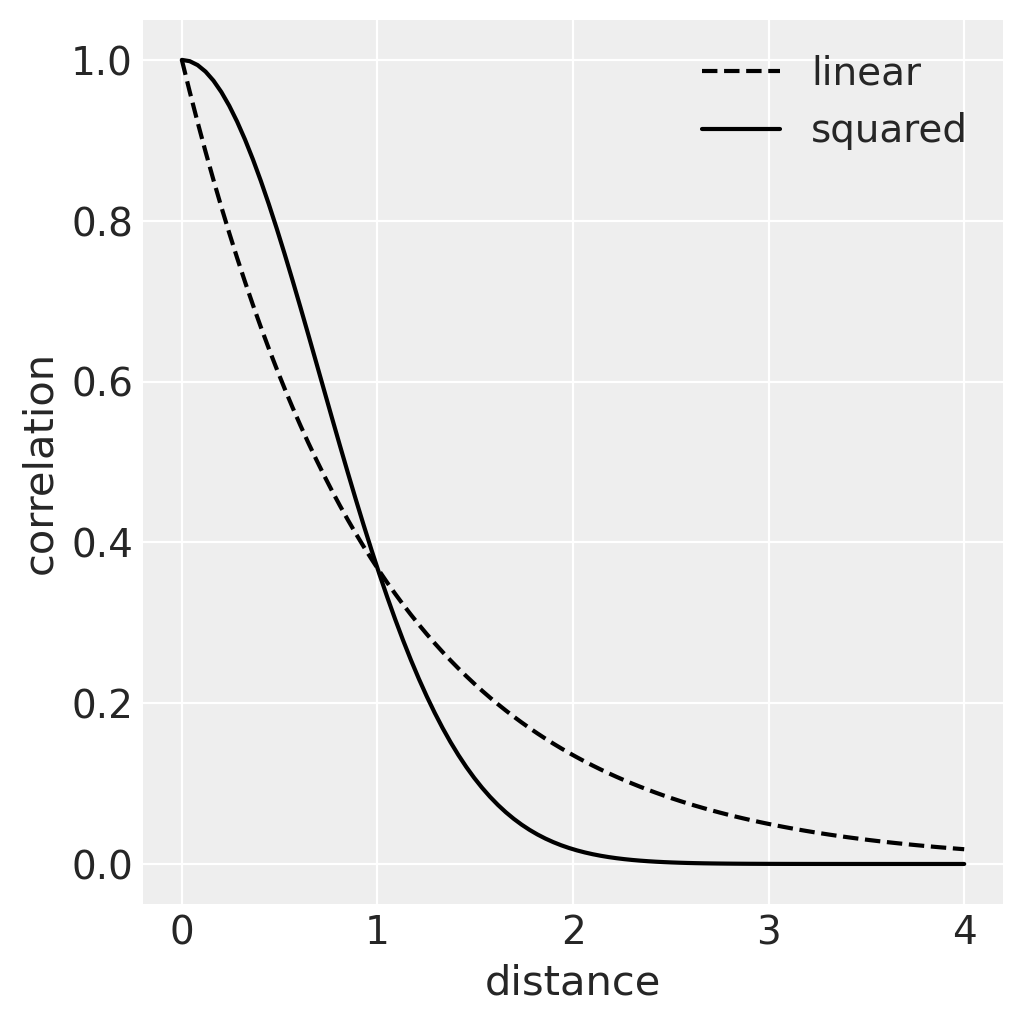

In [5]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

xrange = np.linspace(0, 4, 100)
# linear
ax.plot(xrange, np.exp(-1 * xrange), "k--", label="linear")
# squared
ax.plot(xrange, np.exp(-1 * xrange**2), "k", label="squared")

ax.set_xlabel("distance")
ax.set_ylabel("correlation")
plt.legend();

In [6]:
# load the ordinary data, now with coordinates
dk = pd.read_csv("Kline2.csv", sep=",")

Nsociety = dk.shape[0]
society = np.arange(Nsociety)
total_tools = dk.total_tools.values

Dmat = Dmat.values
Dmatsq = np.power(Dmat, 2)

P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0, see chp 11

dk

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


In [8]:
with pm.Model() as m14_8:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P**b / g) * pm.math.exp(k[society]) #I have replaced Aesara reference

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    trace_14_8 = pm.sample(4000, tune=2000, target_accept=my_target_accept, random_seed=RANDOM_SEED)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g, etasq, ls_inv, k_rotated_]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 2372 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 550 divergences after tuning. Increase `target_accept` or reparameterize.


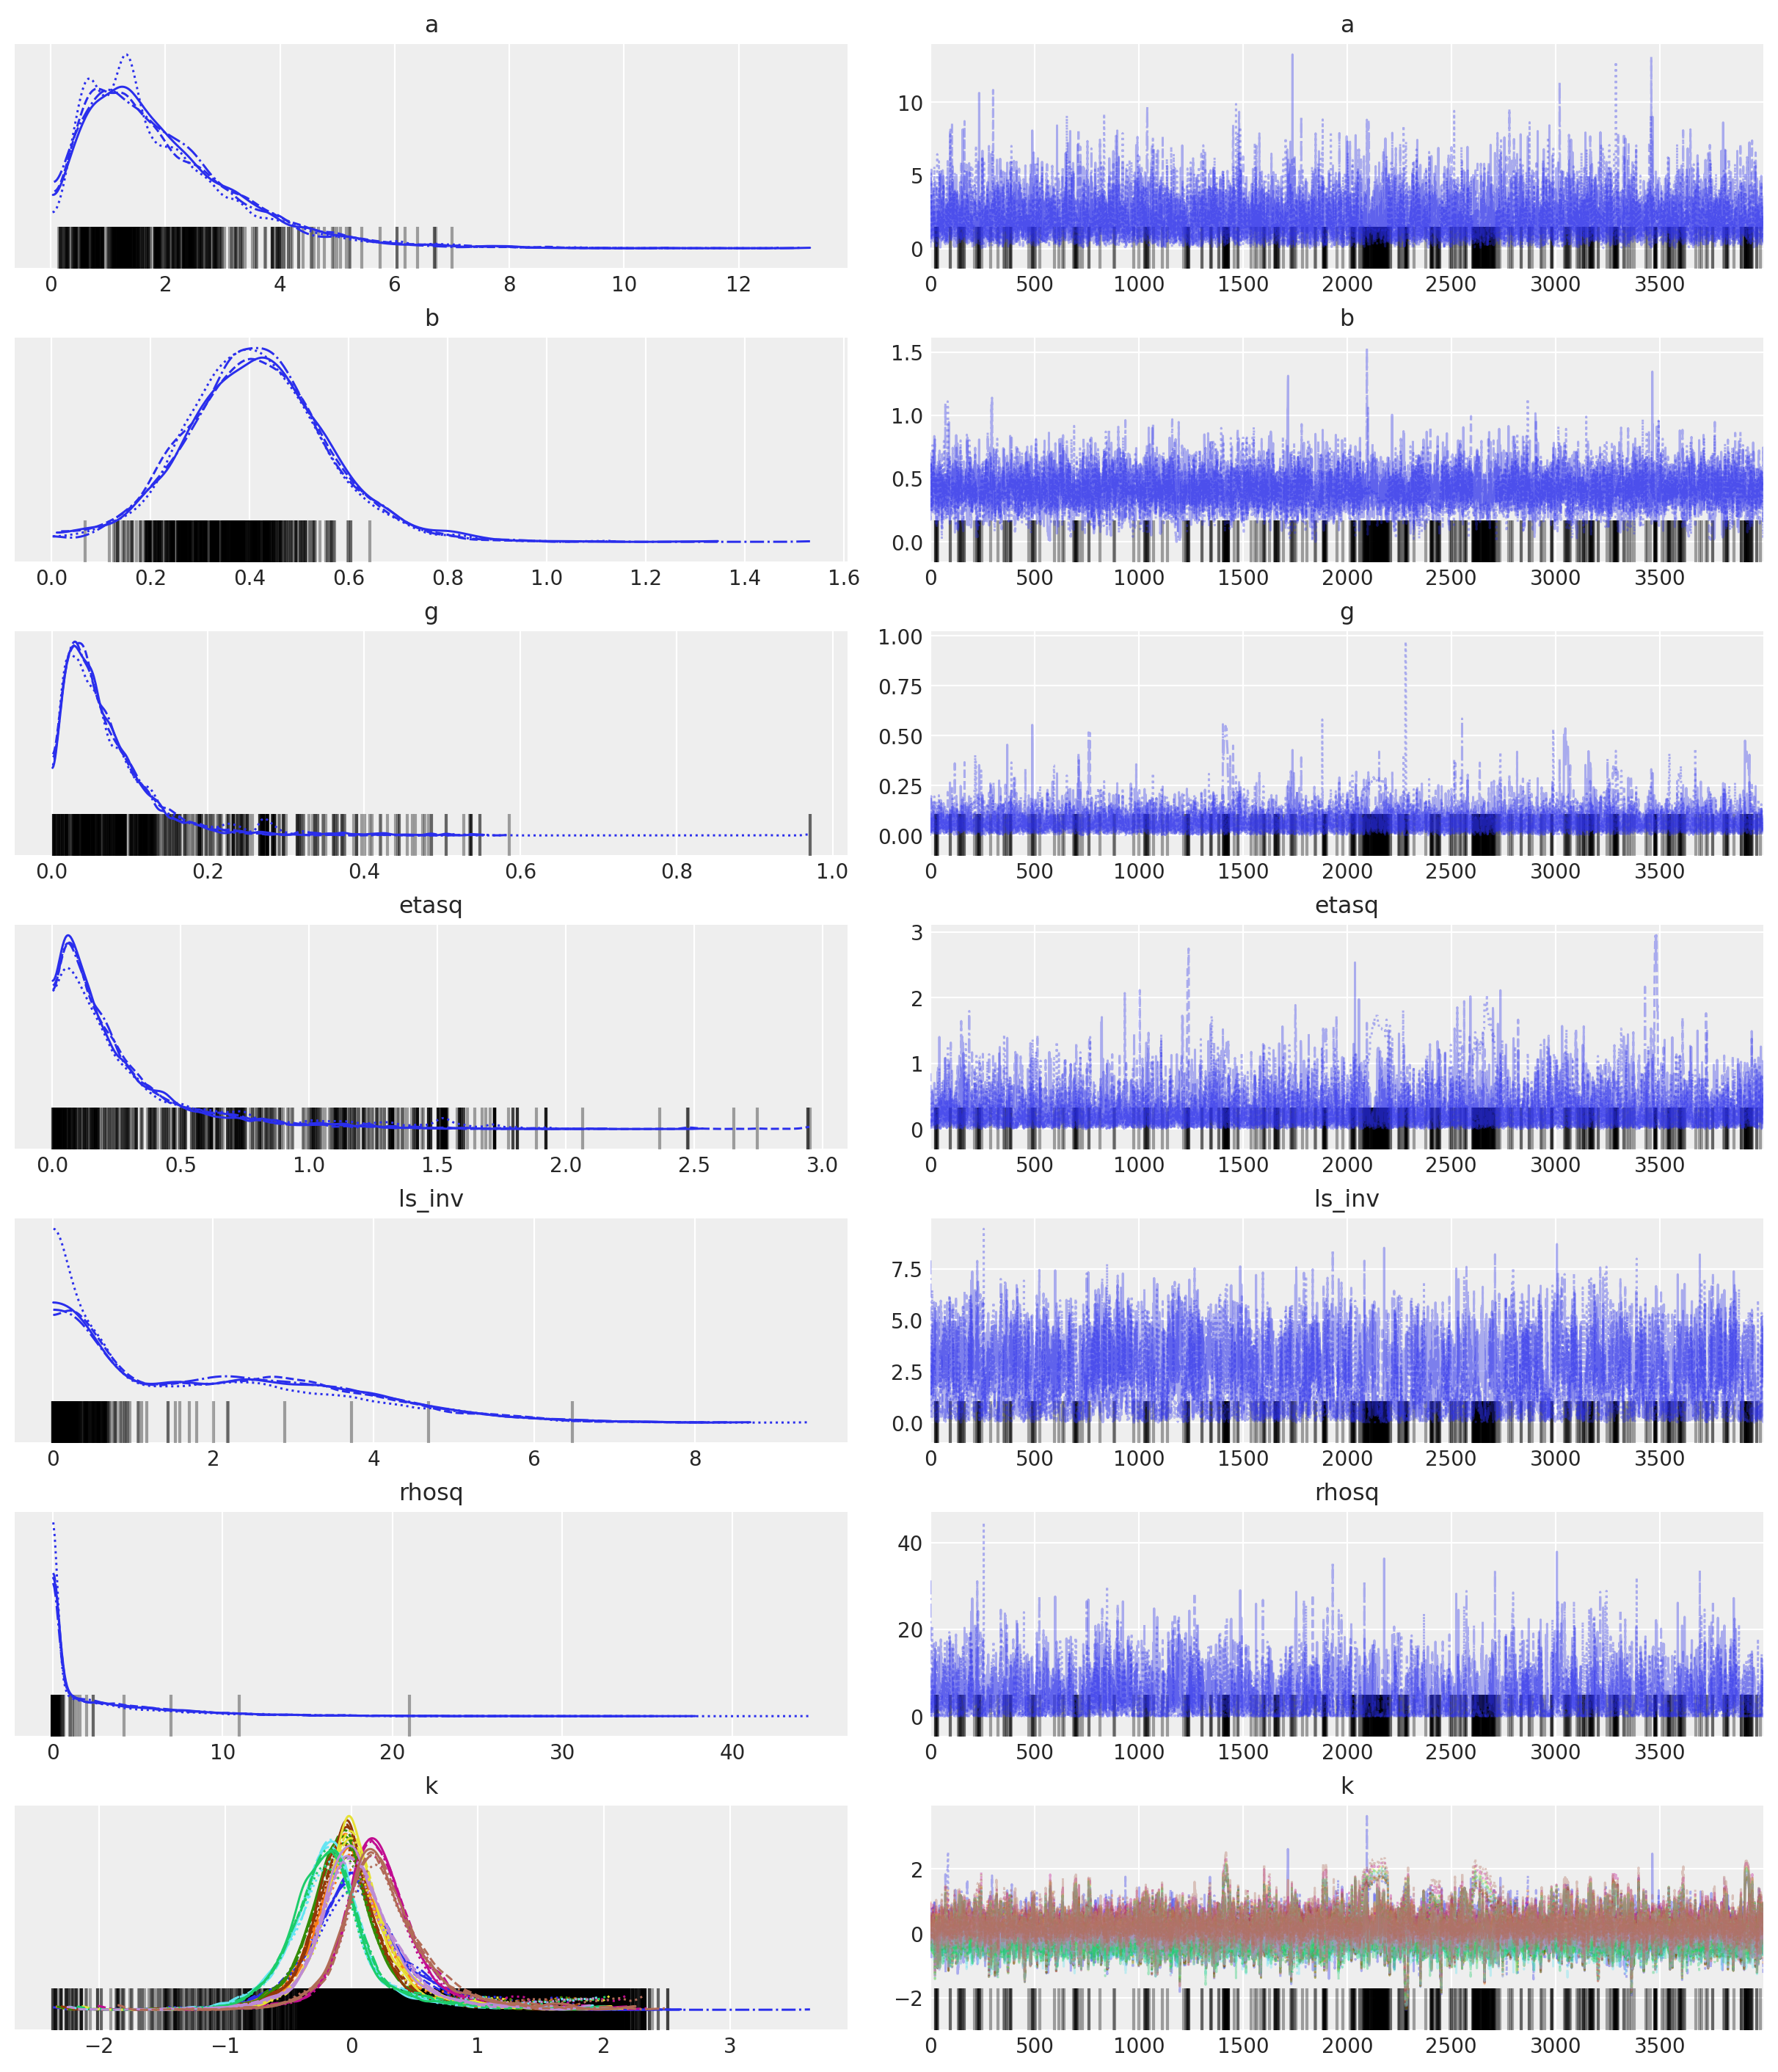

In [9]:
az.plot_trace(trace_14_8, var_names=["~k_rotated_"], compact=True);

In [10]:
az.summary(trace_14_8, var_names=["~k_rotated_"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.93,1.37,0.12,3.68,0.02,0.01,6340.46,5509.53,1.00
b,0.41,0.14,0.18,0.63,0.00,0.00,4595.49,3885.31,1.00
g,0.07,0.06,0.00,0.13,0.00,0.00,2175.97,574.99,1.00
etasq,0.28,0.32,0.00,0.63,0.02,0.01,1379.50,488.21,1.01
ls_inv,1.96,1.61,0.00,4.15,0.05,0.04,697.92,383.69,1.01
rhosq,3.23,4.34,0.00,8.61,0.10,0.07,697.92,383.69,1.01
k[0],0.07,0.46,-0.64,0.77,0.02,0.01,1475.56,490.61,1.01
k[1],0.04,0.42,-0.57,0.64,0.02,0.02,1287.70,404.41,1.01
k[2],-0.03,0.41,-0.66,0.47,0.02,0.02,1061.02,265.46,1.01
k[3],0.27,0.42,-0.34,0.80,0.02,0.02,1291.02,302.91,1.01


In [11]:
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
post = trace_14_8.posterior.stack(sample=("chain", "draw"))
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))


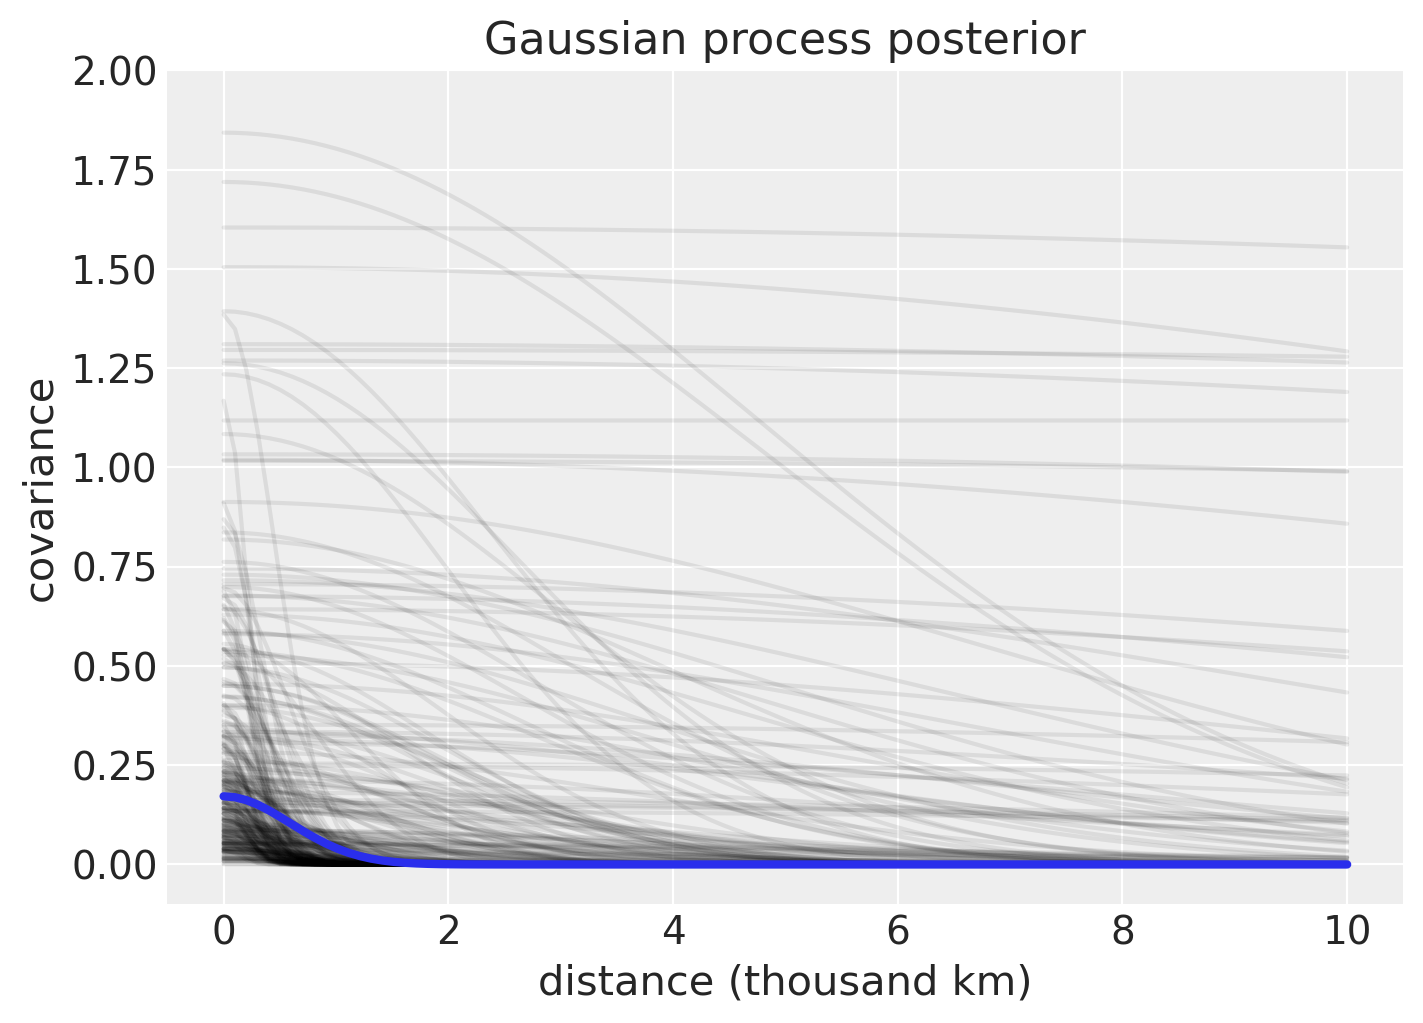

In [12]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)

ax.set(
    title="Gaussian process posterior",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
);

In [13]:
# compute posterior median covariance among societies
K = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * Dmatsq) + np.diag(
    [0.01] * Nsociety
)

In [14]:


# convert to correlation matrix
sigma_post = np.sqrt(np.diag(K))
Rho = (sigma_post**-1) * K * (sigma_post**-1)

# add row/col names for convenience
Rho = pd.DataFrame(
    Rho,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho.round(2)



,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.68,0.54,0.00,0.11,0.00,0.00,0.00,0.01,0.0
Ti,0.68,1.00,0.82,0.00,0.11,0.00,0.00,0.00,0.00,0.0
SC,0.54,0.82,1.00,0.00,0.03,0.01,0.00,0.00,0.00,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.00,0.03,0.02,0.00,0.0
Fi,0.11,0.11,0.03,0.00,1.00,0.00,0.00,0.00,0.41,0.0
Tr,0.00,0.00,0.01,0.00,0.00,1.00,0.01,0.34,0.00,0.0
Ch,0.00,0.00,0.00,0.03,0.00,0.01,1.00,0.12,0.00,0.0
Mn,0.00,0.00,0.00,0.02,0.00,0.34,0.12,1.00,0.00,0.0
To,0.01,0.00,0.00,0.00,0.41,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


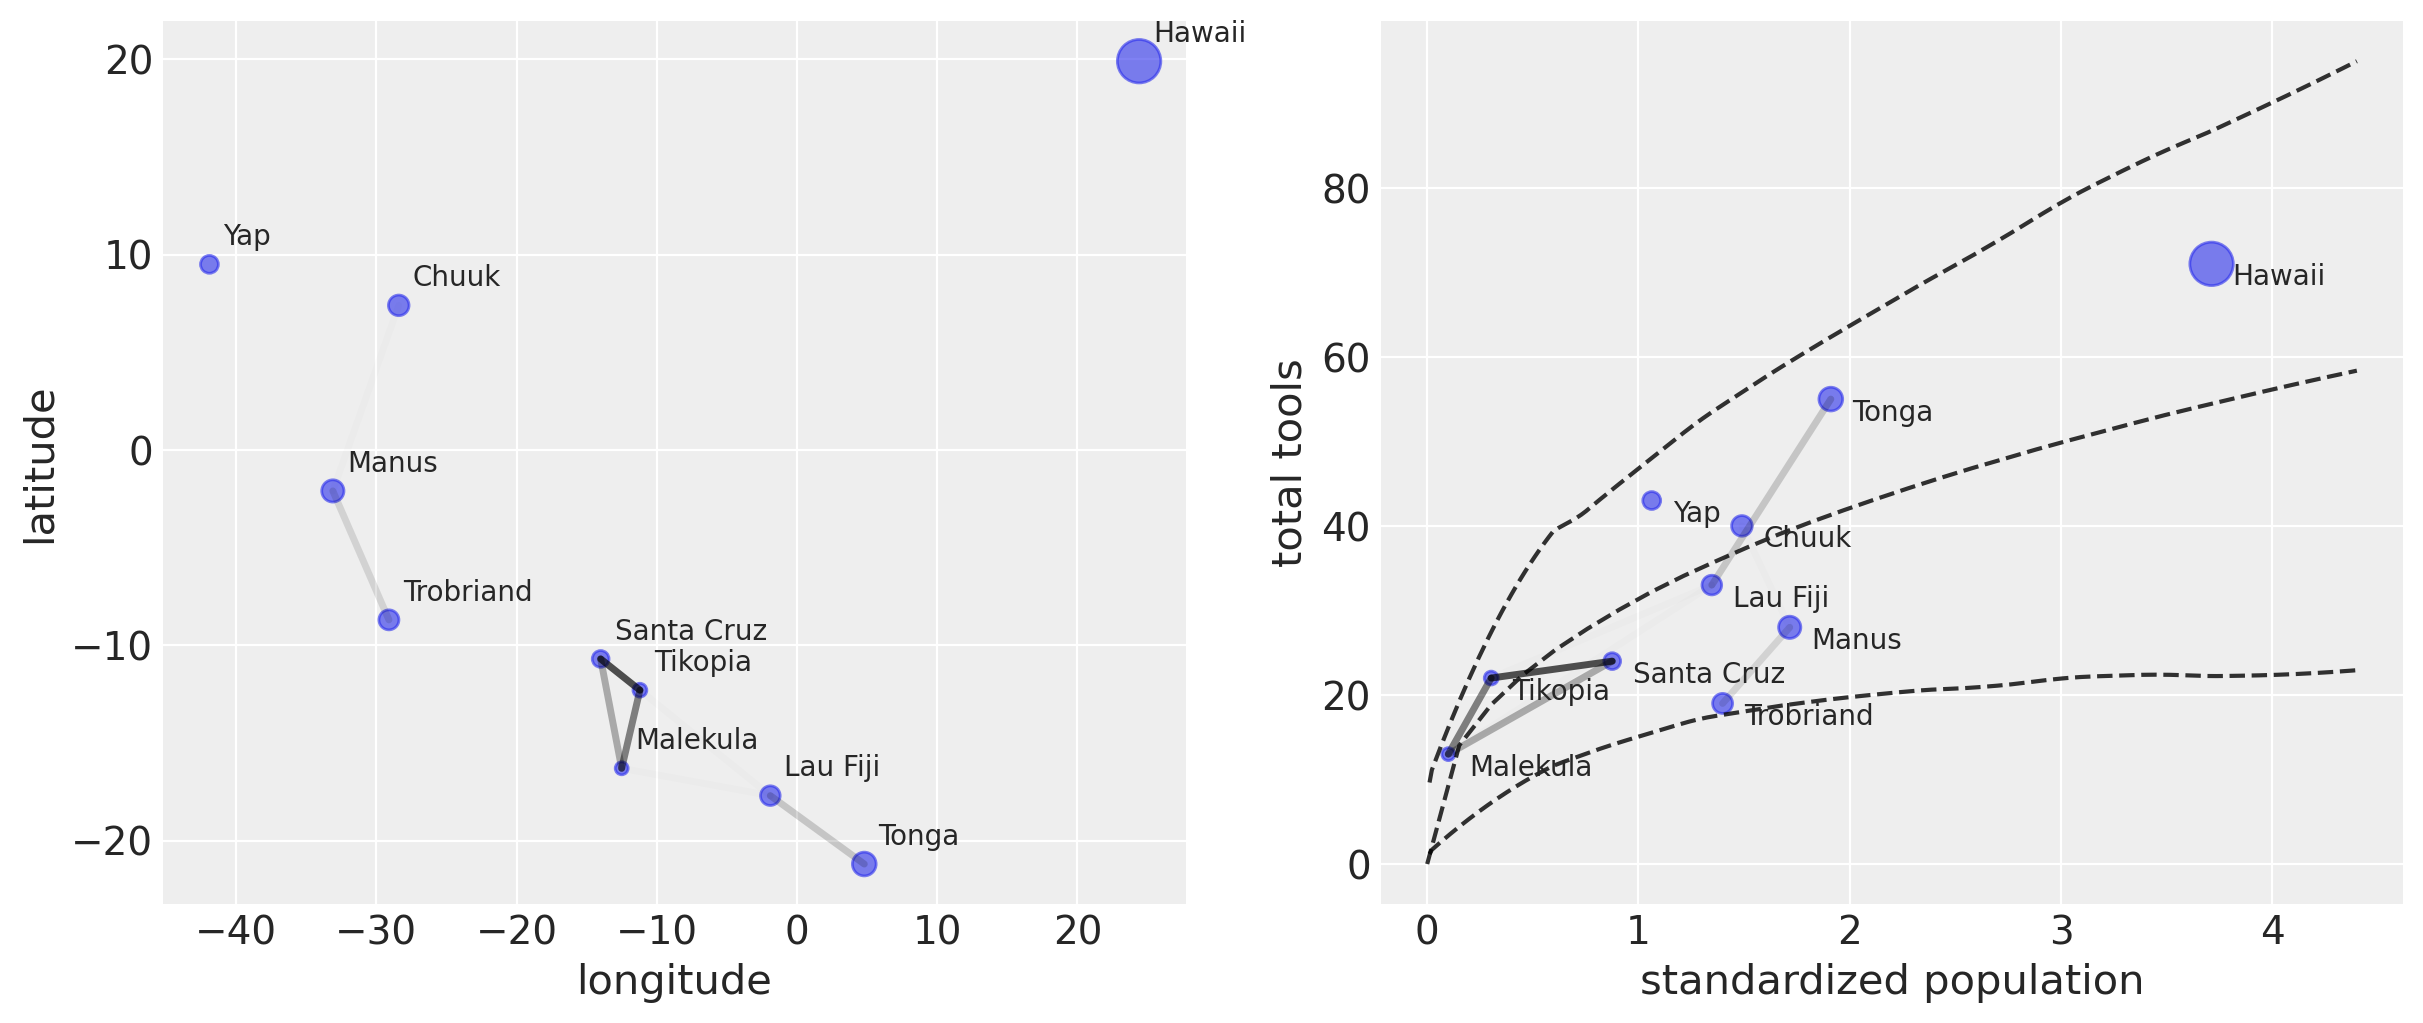

In [15]:
# Code 14.44
# scale point size to logpop
logpop = np.copy(dk["logpop"].values)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# plot raw data and labels
ax0.scatter(dk["lon2"], dk["lat"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax0.text(dk["lon2"][i] + 1, dk["lat"][i] + 1, itext)

# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax0.plot(
            [dk["lon2"][i], dk["lon2"][j]],
            [dk["lat"][i], dk["lat"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax0.set_xlabel("longitude")
ax0.set_ylabel("latitude")

# Code 14.45
# compute posterior median relationship, ignoring distance
P_seq = np.linspace(-1.4, 3.0, 30) + 1.4  # our little trick from chp 11
lambda_post = (
    post["a"].values[:, None] * P_seq ** post["b"].values[:, None] / post["g"].values[:, None]
)

# plot raw data and labels
ax1.scatter(P, dk["total_tools"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax1.text(P[i] + 0.1, dk["total_tools"][i] - 2.5, itext)

# display posterior predictions
ax1.plot(P_seq, np.median(lambda_post, axis=0), "--", color="k", alpha=0.8)
az.plot_hdi(
    P_seq,
    lambda_post,
    color="k",
    ax=ax1,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"color": "k", "ls": "--", "alpha": 0.8},
)

# overlay correlations
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax1.plot(
            [P[i], P[j]],
            [dk["total_tools"][i], dk["total_tools"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax1.set_xlabel("standardized population")
ax1.set_ylabel("total tools");
